In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import pickle, os, time

import entropy

basedir, desc = 'saveddata/Regression/v5sq-eta', 'Regression'
basedir, desc = 'saveddata/MNIST/v1', 'MNIST'
#basedir = 'saveddata/Regression/v6sq-eta-10'
#basedir = 'saveddata/NoisyClassifier/v5sq'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
vals = {'VIB'  : {'tst' : {}, 'trn' : {}}, 
        'nlIB' : {'tst' : {}, 'trn' : {}}}

for fname in os.listdir(basedir):
    with open(basedir + '/' + fname, 'rb') as f:
        if fname.endswith('-base') or fname.startswith('_tf_basemodel') or fname=='checkpoint':
            continue
        _, mode, _, _ = fname.split("-")
        cfg, saved_data = pickle.load(f)
        lrow = saved_data[-1]
        var, beta = lrow['noisevar'], lrow['beta']
        for r in ['trn','tst']:
            l     = lrow[r]
            mx    = l['activations']
            n, d  = mx.shape
            mcH   = entropy.get_mc_entropy(mx, var)
            hCond = entropy.gaussian_entropy_np(d, var)
            l['Ixt_mc'] = mcH - hCond
            print('%30s %s epoch: %d beta: %0.4f Ixt: %0.2f-%0.2f (%0.2f) Iyt: %0.2f' % 
                  (fname, r, lrow['epoch'], beta, l['Ixt_lb'], l['Ixt'], l['Ixt_mc'], l['Iyt']))

            if beta not in vals[mode][r] or \
               (mcXT <= vals[mode][r][beta]['Ixt_mc'] and yt >= vals[mode][r][beta]['Iyt']):
                vals[mode][r][beta] = lrow[r]
                if False:
                    plt.figure()
                    plt.scatter(mx[:,0], mx[:,1], s=l['noisevar'], alpha=.3)
                    plt.title('beta=%.4f mode=%s'%(beta, mode))
            


      results-VIB-0.00100-run0 trn epoch: 150 beta: 0.0010 Ixt: 2.99-3.54 (2.95) Iyt: 2.28
      results-VIB-0.00100-run0 tst epoch: 150 beta: 0.0010 Ixt: 2.99-3.54 (2.96) Iyt: 2.28
     results-nlIB-0.00100-run0 trn epoch: 150 beta: 0.0010 Ixt: 3.40-4.04 (3.37) Iyt: 2.30
     results-nlIB-0.00100-run0 tst epoch: 150 beta: 0.0010 Ixt: 3.42-4.07 (3.38) Iyt: 2.29
      results-VIB-0.00245-run0 trn epoch: 150 beta: 0.0024 Ixt: 7.34-7.37 (2.76) Iyt: 2.27
      results-VIB-0.00245-run0 tst epoch: 150 beta: 0.0024 Ixt: 7.34-7.37 (2.82) Iyt: 2.26
     results-nlIB-0.00245-run0 trn epoch: 150 beta: 0.0024 Ixt: 2.76-3.02 (2.67) Iyt: 2.30
     results-nlIB-0.00245-run0 tst epoch: 150 beta: 0.0024 Ixt: 2.76-3.03 (2.66) Iyt: 2.30
      results-VIB-0.00599-run0 trn epoch: 150 beta: 0.0060 Ixt: 2.35-2.69 (2.45) Iyt: 2.24
      results-VIB-0.00599-run0 tst epoch: 150 beta: 0.0060 Ixt: 2.35-2.68 (2.43) Iyt: 2.23
     results-nlIB-0.00599-run0 trn epoch: 150 beta: 0.0060 Ixt: 2.53-2.67 (2.49) Iyt: 2.30

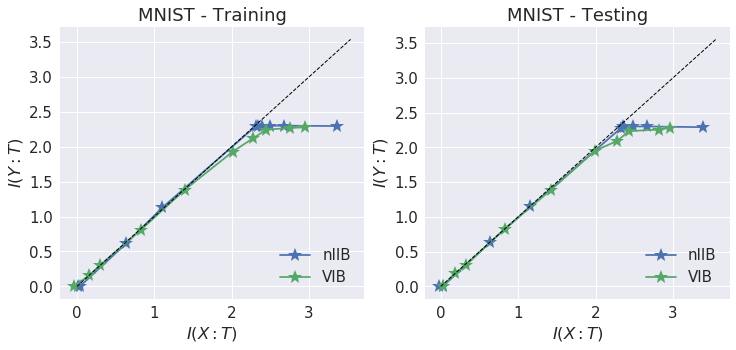

In [46]:
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.5)

plt.figure(figsize=(12,5))
for rndx, r in enumerate(['trn','tst']):
    plt.subplot(1,2,rndx+1)
    for mode in ['nlIB', 'VIB']:
        d = vals[mode][r]
        bvals = sorted(d.keys())
        xt   = [d[b]['Ixt'] for b in bvals]
        xtlb = [d[b]['Ixt_lb'] for b in bvals]
        xtmc = np.array([d[b]['Ixt_mc'] for b in bvals])
        yt   = np.array([d[b]['Iyt'] for b in bvals])
        plt.plot(xtmc, yt, marker='*', markersize=15, label=mode)
        #plt.fill_betweenx(yt, xtlb, xt, alpha=0.3, label=mode)
    plt.ylabel('$I(Y:T)$')
    plt.xlabel('$I(X:T)$')
    #plt.ylim([0, 1.1*plt.ylim()[1]])
    #plt.xlim([0, 1.1*plt.xlim()[1]])
    maxv = max([plt.ylim()[1], plt.xlim()[1]])
    plt.plot([0, maxv], [0,maxv], 'k--', lw=1)
    plt.legend(loc='lower right')
    plt.title(desc + ' - ' + {'tst':'Testing', 'trn':'Training'}[r])
    
    if False and 'Regression' in basedir:
        with open('data/regression-10-100.pkl', 'rb') as f:
            data = pickle.load(f)
        mx = np.hstack([data[r+'_data'], data[r+'_labels']])
        xdims = data[r+'_data'].shape[1]
        xs, ys = entropy.get_gib_curve(np.cov(mx.T.astype('float64')), xdims)
        #print(xs, ys)
        plt.plot(xs/10, ys, c='k',label='Optimal')
    
    

    
    
    
    

In [ ]:

#print(vals['nlIB']['trn'][.05])
plt.figure()
plt.scatter(*vals['VIB']['tst'][.05]['act'].T, s=vals['VIB']['tst'][.05]['noisevar'], alpha=0.1)
plt.figure()
plt.scatter(*vals['nlIB']['tst'][.05]['act'].T, s=vals['nlIB']['tst'][.05]['noivarvar'], alpha=0.1)
#print(get_mc(vals['nlIB']['trn'][.95]['noisevar'])


In [ ]:
covXY = np.cov(mx.T.astype('float64'))
covX = covXY[:xdims,:xdims]
covY = covXY[xdims:,xdims:]
covXgY = covX - covXY[:xdims,xdims:].dot(np.linalg.inv(covY)).dot(covXY[xdims:,:xdims])
mainMx = covXgY.dot(np.linalg.inv(covX))

evecs, evals = np.linalg.eig(mainMx)
evecs = np.abs(evecs) # print(evecs, np.real(evecs))
#print(evecs.min(), evecs.max())
assert(np.all(evecs >= -1e-5) and np.all(evecs <= 1+1e-5))
ix = np.argsort(evecs)
sorted_evecs = evecs[ix]
sorted_evecs
